# 16-10  SRGAN을 이용해 Super Resolution 도전하기

### [SRGAN 사전학습]
- SRGAN에서는 생성된 고해상도 이미지와 실제 고해상도 이미지를 VGG에 입력하여 모델 중간에서 추출해낸 특징을 비교해서 content loss를 계산
- content loss 및 GAN을 사용함으로써 발생하는 adversarial loss를 합하여 최종적으로 perceptual loss(지각손실)라고 정의하며 이를 학습에 이용

#### 1) 생성자 구현
![SRGAN 구현하기](https://user-images.githubusercontent.com/70866993/133122758-c7e84caf-939a-418e-b46e-caf928ad1310.png)
- PReLU :  LeakyReLU에서는 음수의 기울기는 고정된 상수였던 반면에 PReLU에서는 학습이 가능한 파라미터로 설정(음수에 대한 그라데이션 추천)
- k9n64s1의 텐서플로우 구현 Conv2D(filters=64, kernel_size=9, strides=1, padding="same")와 같다.

#### 2) 판별자 구현
![SRGAN Discriminator](https://user-images.githubusercontent.com/70866993/133123180-406ecd26-e7a6-427e-9728-aadaca1ff53b.png)
-  LeakyReLU :  입력 값이 음수일 때 완만한 선형 함수를 그려줍니다. (음수 기울기 상수 값, 일반적으로 알파를 0.01로 설정)

## 프로젝트 1-1.

- 1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
- 2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. cv2.resize()를 사용해 봅시다.
- 3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.
- 4. 2의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 cv2.resize()를 사용해 봅시다.
- 5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
- 6. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

####  데이터 준비하기

(768, 1024, 3)


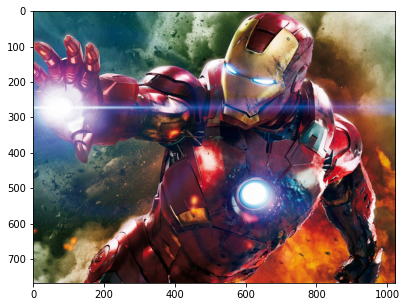

In [2]:
# 1. 이미지 다운로드 (www.10wallpaper.com)  *image

file_path = os.getenv('HOME')+'/aiffel/super_resolution/wallpaper.jpg'
image = cv2.imread(file_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(image.shape) # 이미지의 크기를 출력합니다.

plt.figure(figsize=(10,5))
plt.imshow(image)

(192, 256, 3)


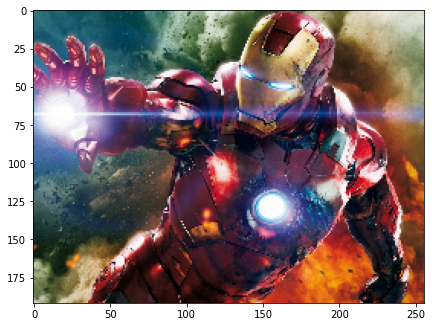

In [3]:
# 2. 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄입니다  *bicubic_lr

bicubic_lr = cv2.resize(image, dsize=(image.shape[1]//4, image.shape[0]//4), interpolation=cv2.INTER_CUBIC) # (가로 픽셀 수, 세로 픽셀 수)

print(bicubic_lr.shape)

plt.figure(figsize=(7,10))
plt.imshow(bicubic_lr)

In [4]:
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [5]:
# 3.함수를 이용해 이전에 사용했던 이미지에 대해 SRGAN의 고해상도 결과를 생성

def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

srgan_hr = apply_srgan(bicubic_lr)
print(srgan_hr.shape)

(768, 1024, 3)


- 메모리 부족으로 OOM 에러가 발생된것으로 확인되어  2650 * 1920 에서 768 * 1024로 이미지 변경하니 문제 없이 실행 되었다. 

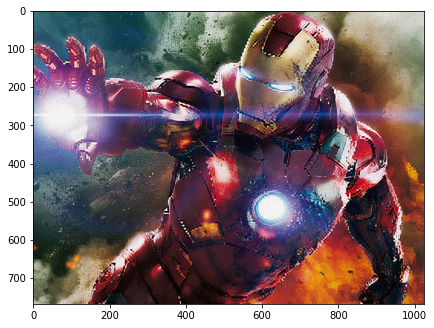

In [6]:
plt.figure(figsize=(7,10))
plt.imshow(srgan_hr)

(768, 1024, 3)


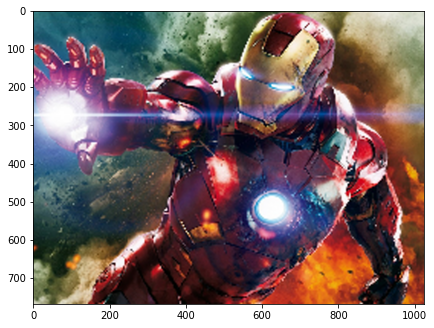

In [7]:
# 4. 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘리기 *bicubic_hr

bicubic_hr = cv2.resize(bicubic_lr,  dsize=(image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC) # (가로 픽셀 수, 세로 픽셀 수)

print(bicubic_hr.shape)

plt.figure(figsize=(7,10))
plt.imshow(bicubic_hr)

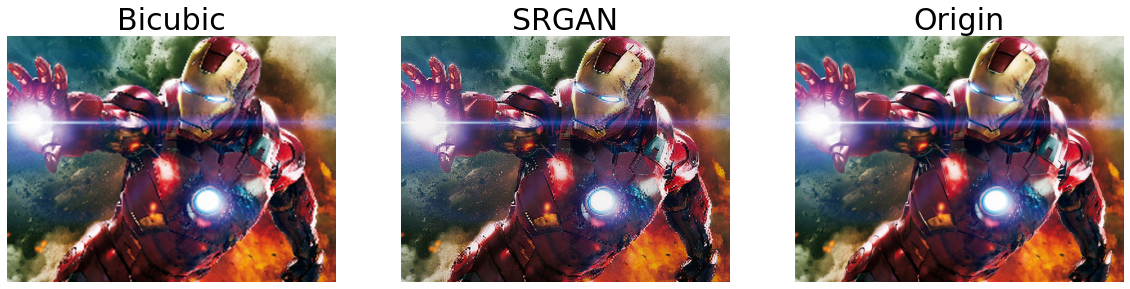

In [8]:
# 5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화

images = [bicubic_hr, srgan_hr, image]
titles = ["Bicubic", "SRGAN", "Origin"]

plt.figure(figsize=(20,10))

for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=30)
    plt.axis('off')

In [9]:
# 특정 부분 잘라서 시각화 해보기

def crop(image, left_top, x=50, y=100):   #특정 영역을 잘라낼 함수를 정의 합니다.
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :] 

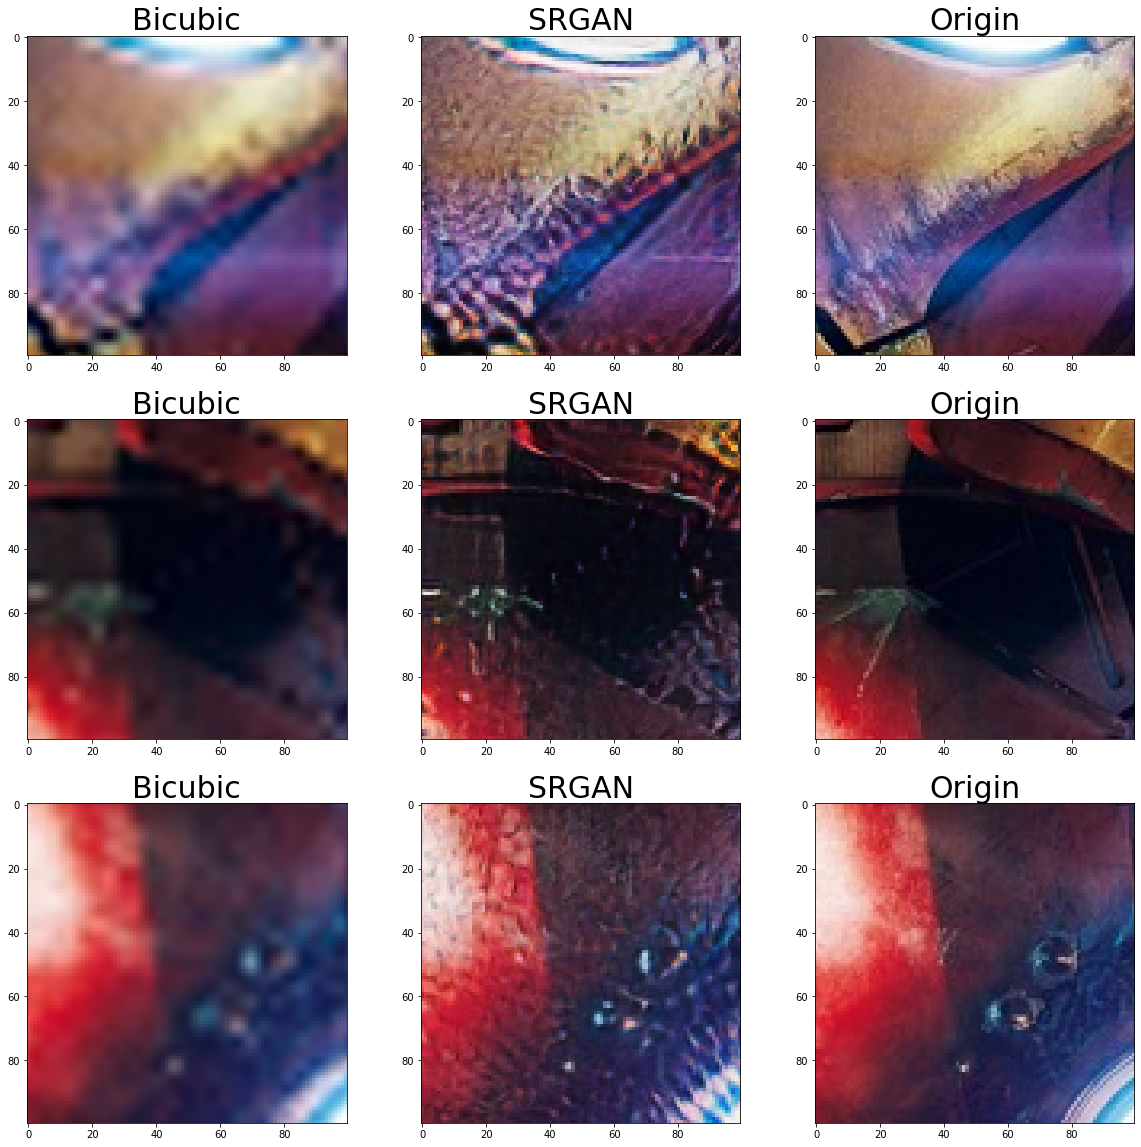

In [10]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.

# 잘라낼 영역의 좌표를 정의합니다.
left_tops = [(200,600), (300,500), (400,500)] 

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 100, 100)  #200으로 수정시 오류발생
    img2 = crop(srgan_hr , left_top, 100, 100)
    img3 = crop(image, left_top, 100, 100)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "Origin"] * 3

plt.figure(figsize=(20,20))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)
 

<mark> 6. 결과 분석
- Bicubic, SRGAN, Origin 전체 이미지에서 Bicubic의 차이는 크게 나지 않았지만 SRGAN의 텍스처가 더 느껴지는듯 하였다. 
- Bicubic, SRGAN, Origin 부분 이미지에서 가장 뚜렸하게 확인 할수 있었는데 Bicubic는 저화질, SRGAN는 텍스처까지 느껴지는 화질, Origin는 약간 smooth한 질감이 느껴졌다.
- 전체 이미지에서는 차이가 나지 않아 성능이 차이는 느끼지 못했지만 얼굴인식등 부분 영역에서는 효과적일것 같다는 생각이 들었다.

## 프로젝트 1-2.

- 1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
- 2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.
- 3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. cv2.resize()를 사용해 봅시다.
- 4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
- 5. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

#### 1. 저해상도 이미지 저장후 불러오기 (www.10wallpaper.com)  *image2 

(275, 458, 3)


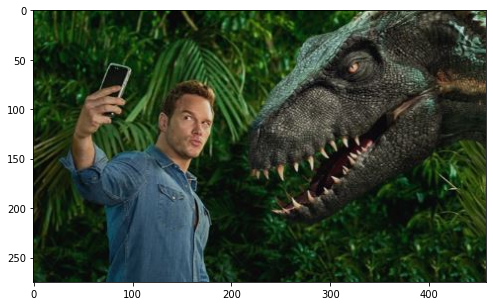

In [21]:
file_path = os.getenv('HOME')+'/aiffel/super_resolution/Jurassic.JPG'
image2 = cv2.imread(file_path)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

print(image2.shape) # 이미지의 크기를 출력합니다.

plt.figure(figsize=(10,5))
plt.imshow(image2)

(68, 114, 3)


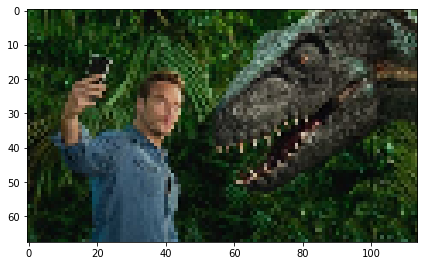

In [22]:
bicubic_Ir2 = cv2.resize(image2,  dsize=(image2.shape[1]//4, image2.shape[0]//4), interpolation=cv2.INTER_CUBIC) # (가로 픽셀 수, 세로 픽셀 수)
print(bicubic_Ir2.shape)

plt.figure(figsize=(7,10))
plt.imshow(bicubic_Ir2)

####  2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성,  이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다

(272, 456, 3)


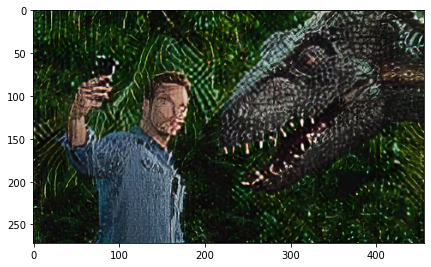

In [23]:
srgan_hr2 = apply_srgan(bicubic_Ir2)
print(srgan_hr2.shape)

plt.figure(figsize=(7,10))
plt.imshow(srgan_hr2)

#### 3. 1. 저해상도 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. cv2.resize()를 사용해 봅시다

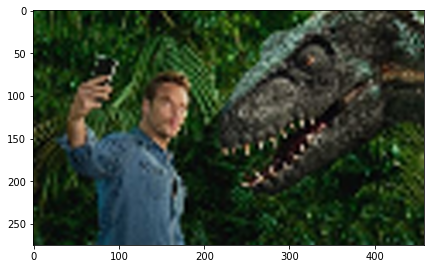

In [24]:
bicubic_hr2 = cv2.resize(bicubic_Ir2, dsize=(image2.shape[1], image2.shape[0]), interpolation=cv2.INTER_CUBIC) # 원본사이즈로 복원

plt.figure(figsize=(7,10))
plt.imshow(bicubic_hr2)

#### 4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화

Text(0.5, 1.0, 'SRGAN')

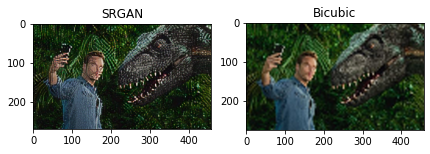

In [26]:
plt.figure(figsize=(7,10))
plt.subplot(1,2,2); plt.imshow(bicubic_hr2); plt.title('Bicubic')
plt.subplot(1,2,1); plt.imshow(srgan_hr2); plt.title('SRGAN')

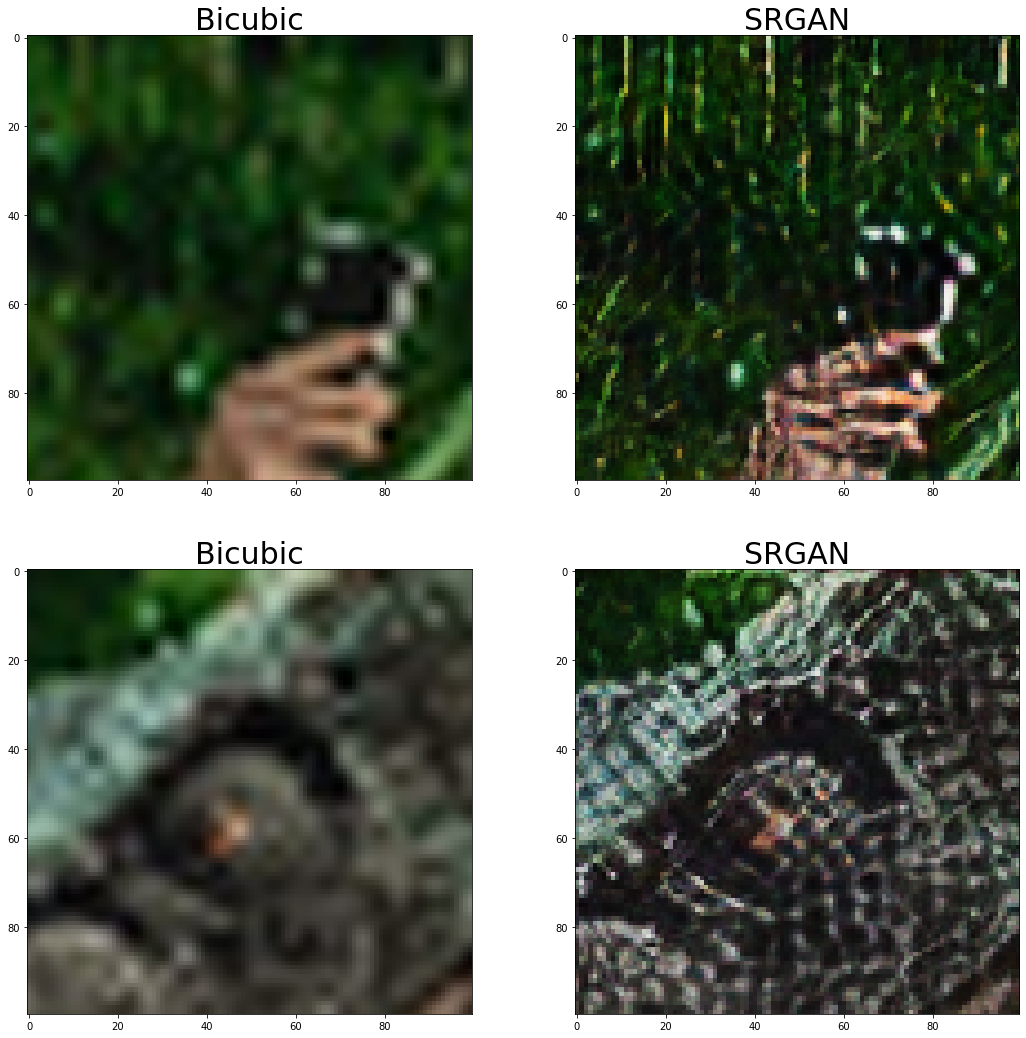

In [41]:
# 자세히 시각화 하기 위해 2개 영역을 잘라냅니다.

left_tops = [(10,10), (0,280)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr2, left_top, 100, 100)
    img2 = crop(srgan_hr2 , left_top, 100, 100)
    images.extend([img1, img2])

labels = ["Bicubic", "SRGAN"] * 2

plt.figure(figsize=(18,18))
for i in range(4):
    plt.subplot(2,2,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

#### 5. 결과분석
- 저화질이라 인물에는 윤곽의 뭉게짐 현상이 나타났고, 파충류는 색이 많지 않아서 그런지 SRGAN 질감이 풍부하게 나온듯하다.
- 여성인물로 다시한번 시도해봤을때 정면 코끝이나, 측면일 경우 윤곽이 많이 뭉게졌다.

## 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기

1. gif 파일 불러오기

In [72]:
import cv2

# 다운받은 파일의 경로를 설정해 주세요.
gif_path = os.getenv('HOME')+'/aiffel/super_resolution'
gif = cv2.VideoCapture(gif_path + '/fire_lr.gif')

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 14
frame 크기 : (282, 300, 3)


2. 프레임별 Super Resolution 진행하기

In [73]:
frames_sr_bicubic = []
for i in frames: 
    bi_i = cv2.resize(i, dsize=(i.shape[0]*4, i.shape[1]*4), interpolation=cv2.INTER_CUBIC) 
    frames_sr_bicubic.append(bi_i)

In [74]:
frames_sr_srgan = []
for i in frames: 
    srgan_i = apply_srgan(i)
    frames_sr_srgan.append(srgan_i)

3. 프레임을 합쳐 gif 만들기

In [62]:
len(frames_sr_bicubic)

8

In [75]:
import imageio

imageio.mimsave(gif_path + "/fire_hr_bicubic.gif", frames_sr_bicubic[:7])
imageio.mimsave(gif_path + "/fire_hr_srgan.gif", frames_sr_srgan[:7])

4. Jupyter notebook에 gif 표시하기
- 깃허브 gif 경로: https://github.com/edupro2000/afiffel-Exploration-stage/issues/18

[원본]
![fire_lr](https://user-images.githubusercontent.com/70866993/133280733-4ceda3be-18ea-4bce-b881-0f664a39c3ae.gif)

[bicubic]
![fire_hr_bicubic](https://user-images.githubusercontent.com/70866993/133280752-15e8763a-1ee2-422d-badd-90cb1a3a79e9.gif)

[srgan]
![fire_hr_srgan](https://user-images.githubusercontent.com/70866993/133280740-45659561-52cb-4da0-bb8a-2ec61ebfe5d4.gif)

- 용량초과로 첨부하지 못했지만 도시 이미지 보다는 불멍의 낙엽을 볼때 srgan이 좀더 화질개선이 잘된것 같다.

## 루브릭
- 생성한 여러 이미지를 시각화했습니다.
- 여러 데이터셋을 사용해 미리 학습된 SRGAN이 확실히 더 성능이 좋았습니다.
- gif 영상을 프레임으로 변환 후 고해상도로 변환했습니다.

## 회고
- 정말 어려운 과제였다. 
- bicubic 의 개념이해가 어려웠고, 프로젝트 1-2  //4 -> 다시 원상복구의 개념인지 과제에 상세 내용이 추가 되었으면 좋겠다. 